<div style="border: 5px solid; border-color: rgb(160, 217, 56); border-radius: 30px; position: relative; width: 95%; height: 300px; display: flex; justify-content: center; align-items: center; background-color: #f0f0f0;">
    <img src="https://cdn.corporatefinanceinstitute.com/assets/money-2.jpeg" style="position: absolute; top: 0; left: 0; width: 100%; height: 100%; z-index: 0; opacity: 1.0; border-radius: 30px">
    <div style="position: relative; z-index: 1; text-align: center; background-color: rgba(73, 50, 41, 0.5); color: orange; display: flex; flex-direction: column; align-items: center; text-align: center; justify-content: center; width: 100%; margin: 10%; padding: 5px; border-radius: 20px">
        <h1 style="text-align: center; width: 100%; font-size: 72px; color:rgb(160, 217, 56)" ><b>Bank Turnover💰💸</b></h1>
    </div>
</div>

# <div style="width: 100%"><h1 style="text-align: center; font-family: 'Roboto', sans-serif; color: rgb(176, 219, 124); background-color: rgba(207, 64, 145, 0.6); padding: 30px; border: 5px solid rgb(176, 219, 124); border-style: solid; border-radius: 10px;"> Imports & Load Data </h1></div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os

base_path = "/kaggle/input/bank-customer-churn-modeling/Churn_Modelling.csv"
df = pd.read_csv(base_path)
TARGET = 'Exited'

import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%matplotlib inline

sns.set()
sns.set_palette('PiYG')
SNS_CMAP = 'PiYG'
colors = sns.palettes.color_palette(SNS_CMAP)
pd.options.mode.chained_assignment = None
from typing import List, Tuple

In [2]:
!pip install -q lightning
import os
from torch import optim, nn, utils, Tensor
import lightning as L
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import torch

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split

# <div style="width: 100%"><h1 style="text-align: center; font-family: 'Roboto', sans-serif; color: rgb(176, 219, 124); background-color: rgba(207, 64, 145, 0.6); padding: 30px; border: 5px solid rgb(176, 219, 124); border-style: solid; border-radius: 10px;"> EDA </h1></div>

In [4]:
df.head().style.background_gradient(cmap=SNS_CMAP)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.000000,1,1,1,101348.880000,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.860000,1,0,1,112542.580000,0
2,3,15619304,Onio,502,France,Female,42,8,159660.800000,3,1,0,113931.570000,1
3,4,15701354,Boni,699,France,Female,39,1,0.000000,2,0,0,93826.630000,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.820000,1,1,1,79084.100000,0


In [5]:
df.describe().iloc[1:].style.background_gradient(cmap=SNS_CMAP)

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
mean,5000.500000,15690940.569400,650.528800,38.921800,5.012800,76485.889288,1.530200,0.705500,0.515100,100090.239881,0.203700
std,2886.895680,71936.186123,96.653299,10.487806,2.892174,62397.405202,0.581654,0.455840,0.499797,57510.492818,0.402769
min,1.000000,15565701.000000,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,2500.750000,15628528.250000,584.000000,32.000000,3.000000,0.000000,1.000000,0.000000,0.000000,51002.110000,0.000000
50%,5000.500000,15690738.000000,652.000000,37.000000,5.000000,97198.540000,1.000000,1.000000,1.000000,100193.915000,0.000000
75%,7500.250000,15753233.750000,718.000000,44.000000,7.000000,127644.240000,2.000000,1.000000,1.000000,149388.247500,0.000000
max,10000.000000,15815690.000000,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [9]:
agg_df = df.agg(["nunique", "unique", lambda x:x.isna().sum(), "dtypes"]).T
agg_df['unique'] = agg_df['unique'].apply(lambda x: x if len(x)<10 else x[:10])
agg_df.style.apply(lambda s: [f'background-color: rgba({colors[2][0]*255}, {colors[2][1]*255}, {colors[2][2]*255}, 0.5)' if i % 2 == 0 else f'background-color: rgba({colors[5][0]*255}, {colors[5][1]*255}, {colors[5][2]*255}, 0.5)' for i in range(len(s))])

,nunique,unique,,dtypes
RowNumber,10000,[ 1 2 3 4 5 6 7 8 9 10],0,int64
CustomerId,10000,[15634602 15647311 15619304 15701354 15737888 15574012 15592531 15656148 15792365 15592389],0,int64
Surname,2932,['Hargrave' 'Hill' 'Onio' 'Boni' 'Mitchell' 'Chu' 'Bartlett' 'Obinna' 'He' 'H?'],0,object
CreditScore,460,[619 608 502 699 850 645 822 376 501 684],0,int64
Geography,3,['France' 'Spain' 'Germany'],0,object
Gender,2,['Female' 'Male'],0,object
Age,70,[42 41 39 43 44 50 29 27 31 24],0,int64
Tenure,11,[ 2 1 8 7 4 6 3 10 5 9],0,int64
Balance,6382,[ 0. 83807.86 159660.8 125510.82 113755.78 115046.74 142051.07 134603.88 102016.72 143129.41],0,float64
NumOfProducts,4,[1 3 2 4],0,int64


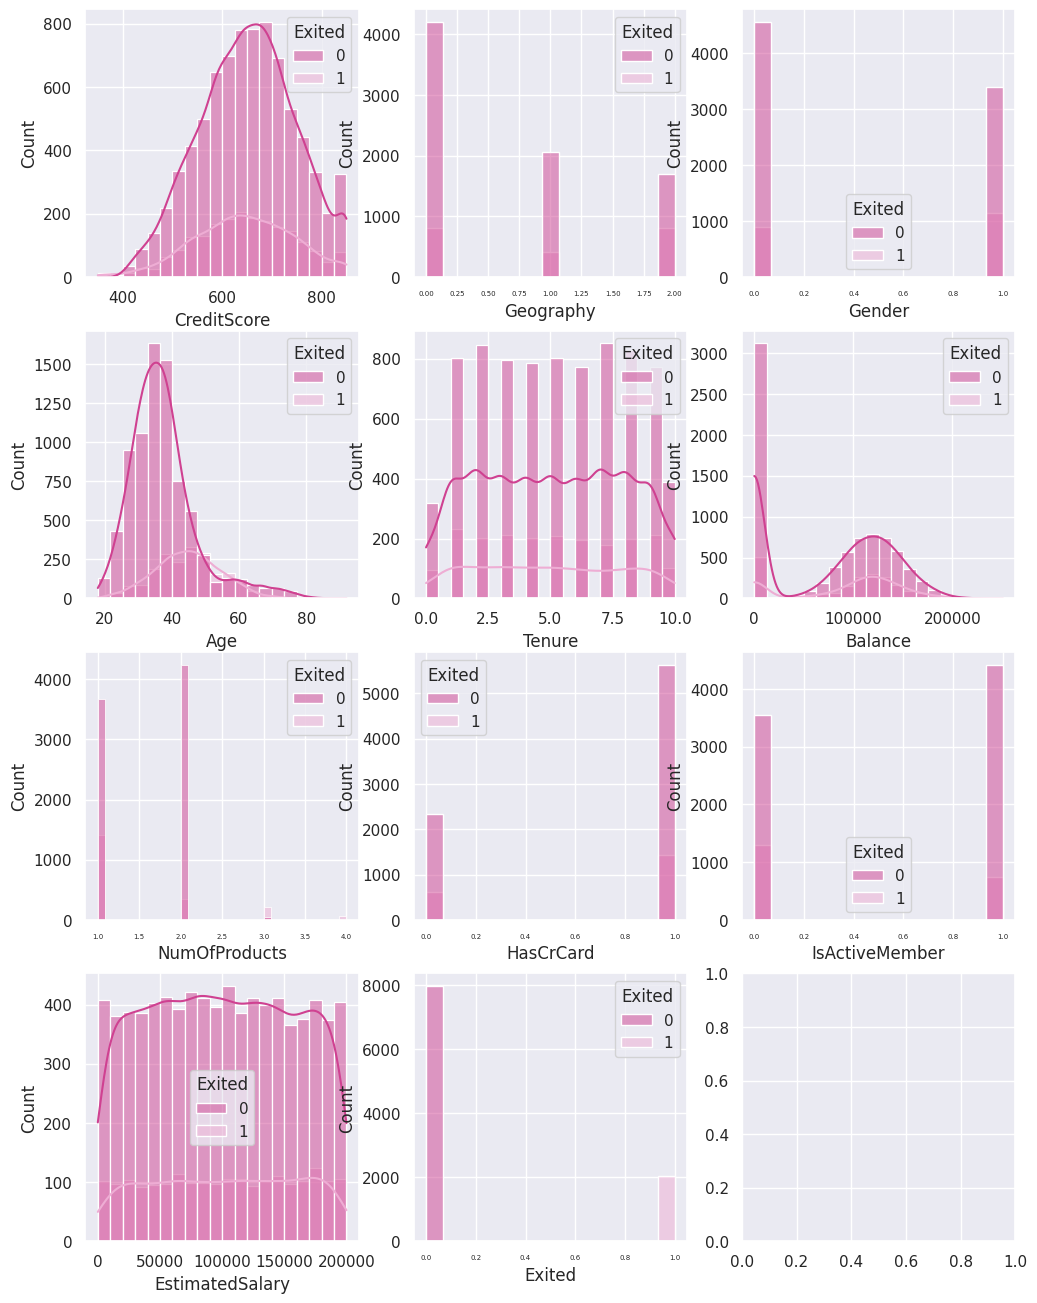

In [6]:
from typing import List

def plot_histograms_binary(df: pd.DataFrame, target: str = "TARGET", cols:List[str]=None, ncols: int = 3)->None:
    """
    Plot a series of histograms for a binary target
    
    Parameters: 
        df (Dataframe) : data to be visualized
        *params : any
    """
    if cols is None:
        cols = df.columns
    nrows = (len(cols)+ncols-1)//ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
    for i, col in enumerate(cols):
        if len(df[col].unique())>10:
            sns.histplot(data=df, x=col, bins=20, hue=TARGET, ax=axes.flatten()[i], kde=True)
        else:
            sns.histplot(df, x=col, hue=TARGET, ax=axes.flatten()[i])
            axes.flatten()[i].tick_params(axis='x', labelsize=5)
    plt.show()

df['Geography'] = df['Geography'].map({'France':0, 'Spain':1, 'Germany':2,})
df['Gender'] = df['Gender'].map({'Male':0, 'Female':1,})

cols = ['CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited']

plot_histograms_binary(df, TARGET, cols)

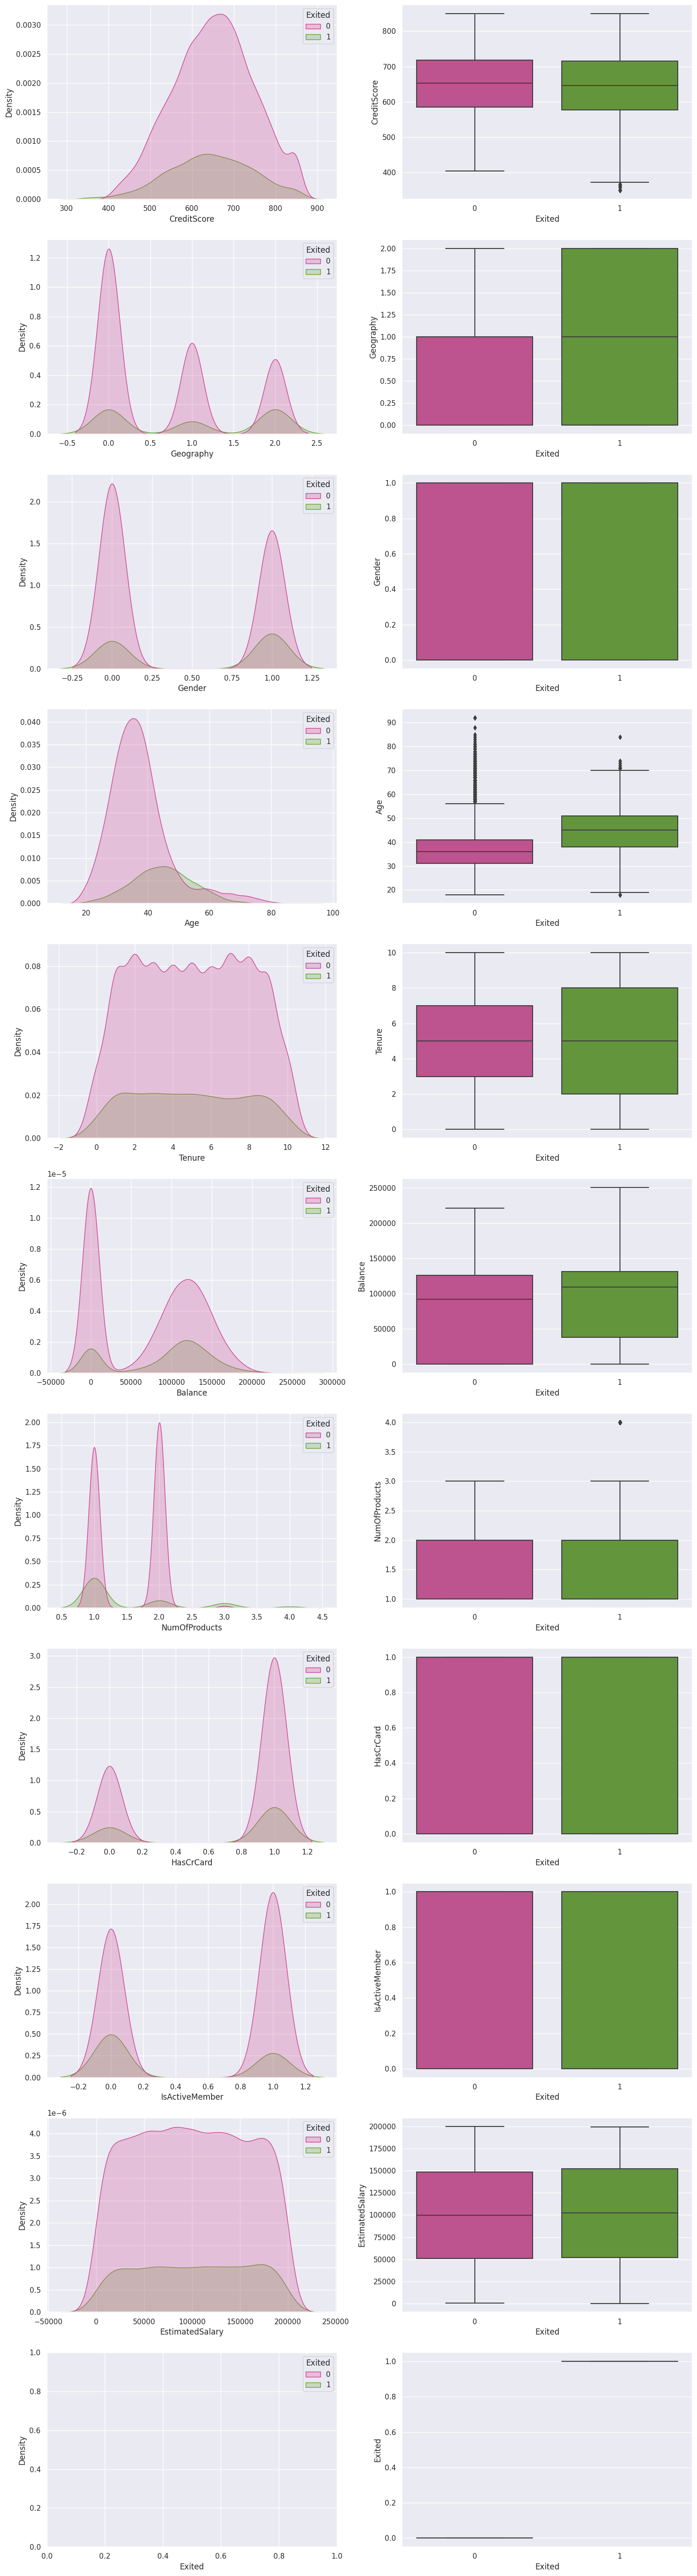

In [7]:
def plot_continous_distributions(df, target, filter_outliers = True, cols=None):
    if cols is None:
        cols = [col for col in df.columns if len(df[col].unique())>10]
    fig,axes = plt.subplots(len(cols), 2,figsize=(15, 5*len(cols)))

    for i, col in enumerate(cols):
        if filter_outliers:
            Q1, Q3 = df[col].quantile(0.2), df[col].quantile(0.8)
            IQR = Q3 - Q1
            lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
            filtered_df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        else:
            filtered_df = df
        sns.kdeplot(data = filtered_df, x=col, hue=df[target], fill=True, ax=axes[i][0], palette={0: colors[0], 1: colors[5]})
        sns.boxplot(df, y=col, x=TARGET, ax=axes[i][1], palette={0: colors[0], 1: colors[5]})
    fig.tight_layout()
    plt.show()
    
plot_continous_distributions(df, TARGET, False, cols)

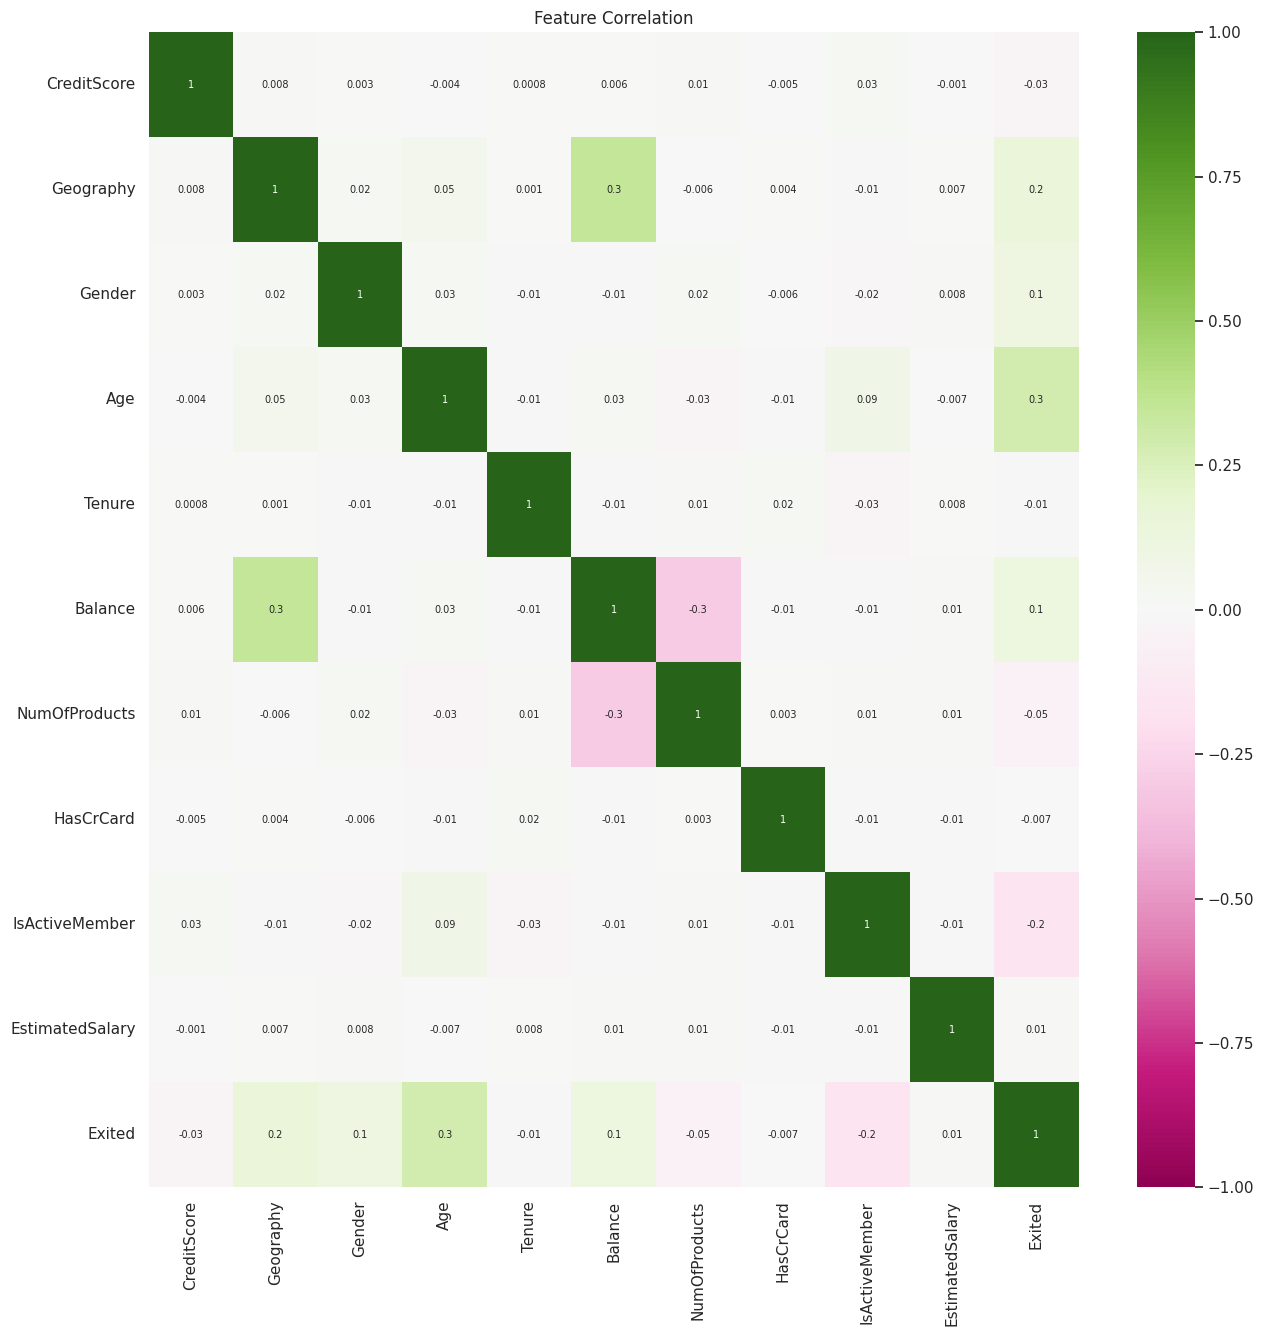

In [11]:
plt.figure(figsize=(15, 15))
sns.heatmap(df[cols].corr(), cmap=SNS_CMAP, annot=True, annot_kws={'fontsize':7}, fmt='.1g', vmin=-1, vmax=1, center= 0)
plt.title("Feature Correlation")
plt.show()

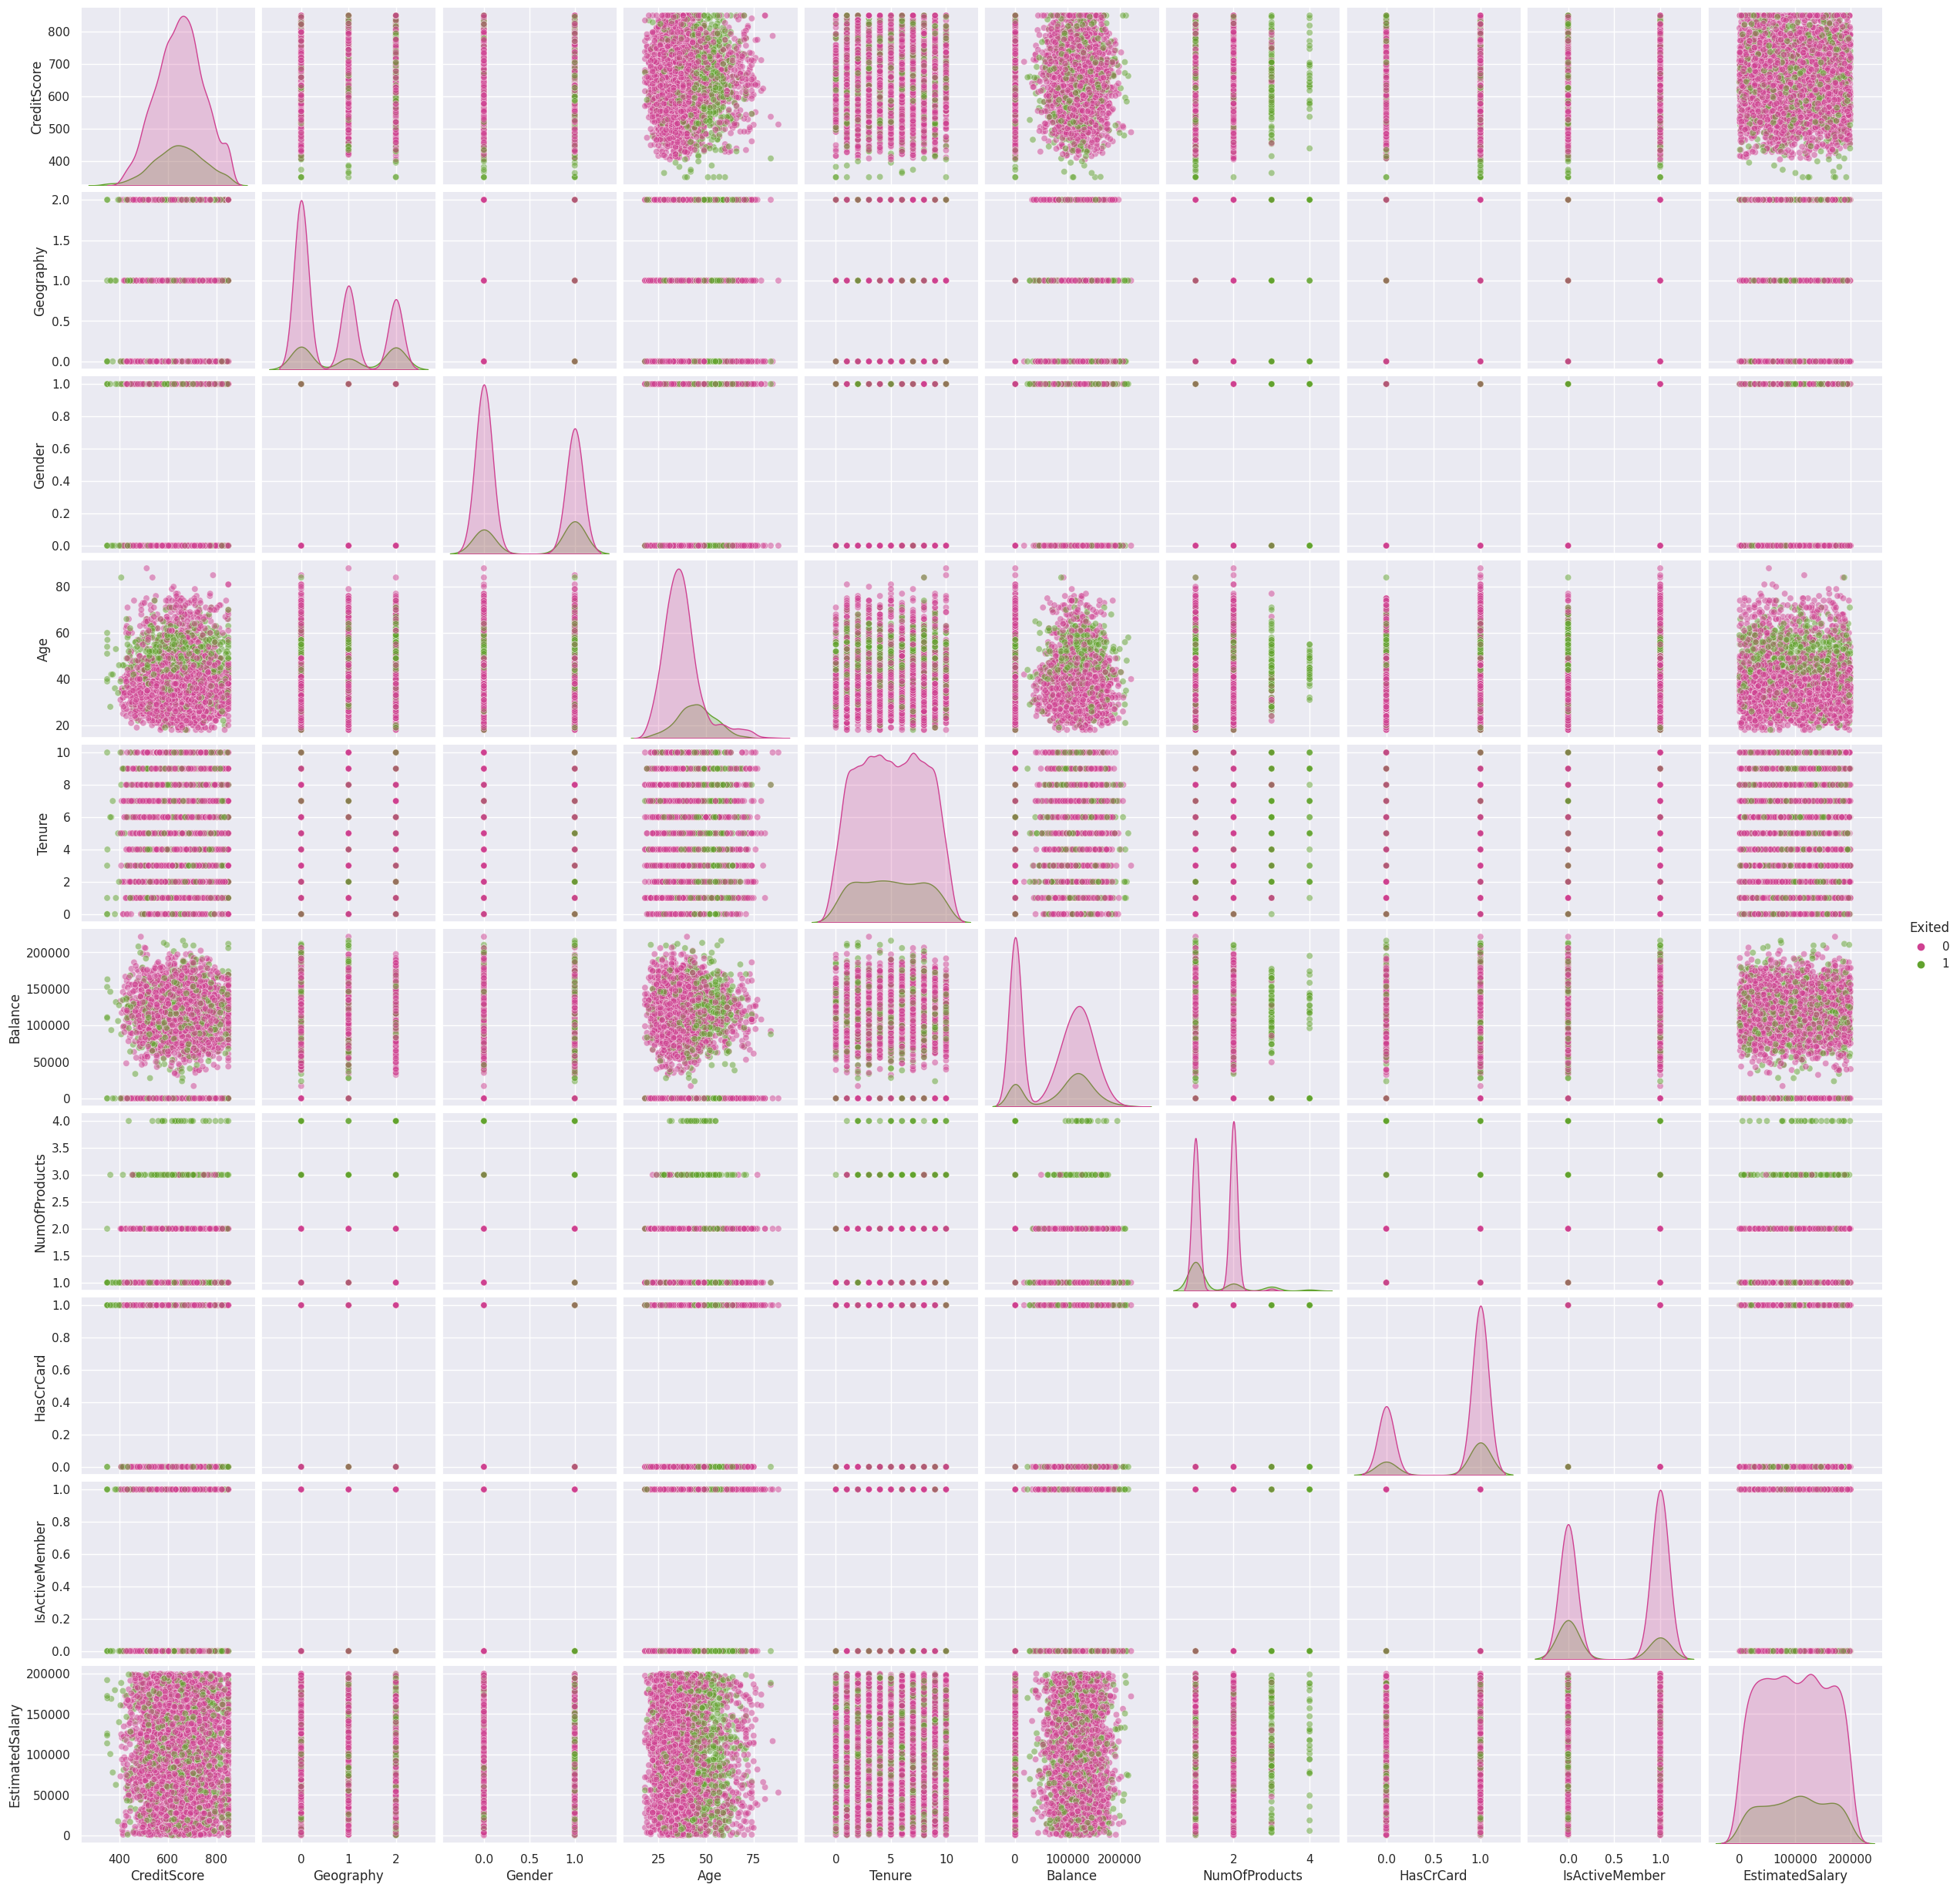

In [17]:
sns.pairplot(df[cols].sample(5000), hue=TARGET, palette={0: colors[0], 1: colors[5]}, plot_kws={'alpha': 0.5})
# fig.suptitle('Pairplots of features')
plt.show()

# <div style="width: 100%"><h1 style="text-align: center; font-family: 'Roboto', sans-serif; color: rgb(176, 219, 124); background-color: rgba(207, 64, 145, 0.6); padding: 30px; border: 5px solid rgb(176, 219, 124); border-style: solid; border-radius: 10px;"> Torch Neural Network </h1></div>

<h3 style="text-align: center; font-family: 'Roboto', sans-serif; color: rgba(238, 173, 211, 1.0); background-color: rgba(97, 163, 46, 0.3); padding: 10px; border-style: solid; border-radius: 10px;"> Preprocessing </h3>

In [3]:
df = pd.read_csv(base_path)

cols = ['CreditScore','Age','Tenure','Balance',
        'NumOfProducts','HasCrCard','IsActiveMember','EstimatedSalary',]
ohe_cols = ['Geography',]
ordinal_cols = ['Gender',]

preprocessor = Pipeline([
    ('encoder', ColumnTransformer(transformers = [
        ('ohe', OneHotEncoder(), ohe_cols),
        ('ordinal', OrdinalEncoder(), ordinal_cols),
        ('pass-trhough', 'passthrough', cols),
    ])),
    ('scaler', StandardScaler()),
])

preprocessor.fit(df)

Pipeline(steps=[('encoder',
                 ColumnTransformer(transformers=[('ohe', OneHotEncoder(),
                                                  ['Geography']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['Gender']),
                                                 ('pass-trhough', 'passthrough',
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'EstimatedSalary'])])),
                ('scaler', StandardScaler())])

In [41]:
X, Y = preprocessor.transform(df), df[TARGET].values
X.shape, Y.shape

((10000, 12), (10000,))

<h3 style="text-align: center; font-family: 'Roboto', sans-serif; color: rgba(238, 173, 211, 1.0); background-color: rgba(97, 163, 46, 0.3); padding: 10px; border-style: solid; border-radius: 10px;"> Torch DataModule  </h3>

In [47]:
class TabularDataModule(L.LightningDataModule):
    
    class TabularDataset(Dataset):
        def __init__(self, features, labels):
            self.features = torch.tensor(features, dtype=torch.float32)
            self.labels = torch.tensor(labels, dtype=torch.long)  

        def __len__(self):
            return len(self.features)

        def __getitem__(self, idx):
            return self.features[idx], self.labels[idx]
        
    def __init__(self, X, Y, batch_size = 64, split=0.2):
        super().__init__()
        self.X, self.Y = X, Y
        self.batch_size = batch_size
        self.split = split
 
    def setup(self, stage):
        X_train, X_val, Y_train, Y_val = train_test_split(self.X, self.Y, test_size=self.split)
        self.train_dataset = self.TabularDataset(X_train, Y_train)
        self.val_dataset = self.TabularDataset(X_val, Y_val)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)
    
data_module = TabularDataModule(X, Y, batch_size=64, split=0.2)
data_module.setup('fit')

<h3 style="text-align: center; font-family: 'Roboto', sans-serif; color: rgba(238, 173, 211, 1.0); background-color: rgba(97, 163, 46, 0.3); padding: 10px; border-style: solid; border-radius: 10px;"> Torch Lightning⚡ Training  </h3>

In [48]:
class BinaryClassifier(L.LightningModule):
    
    def __init__(self, input_dim):
        super(BinaryClassifier, self).__init__()
        self.linear1 = nn.Linear(input_dim, 64)
        self.linear2 = nn.Linear(64, 32)
        self.linear3 = nn.Linear(32, 2)
        self.activation = torch.relu
        
    def forward(self, x):
        x = self.activation(self.linear1(x))
        x = self.activation(self.linear2(x))
        x = self.linear3(x)
        return x
                            
    def cross_entropy_loss(self, logits, labels):
        return F.nll_loss(logits, labels)
                            
    def training_step(self, batch, batch_idx):
        x, y= batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y= batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        self.log('val_loss', loss)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [53]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

trainer = L.Trainer(max_epochs=50, callbacks=[EarlyStopping(monitor="val_loss", mode="min")])
trainer.fit(BinaryClassifier(X.shape[1]), datamodule=TabularDataModule(X, Y, batch_size=64, split=0.2))

INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
  | Name    | Type   | Params | Mode 
-------------------------------------------
0 | linear1 | Linear | 832    | train
1 | linear2 | Linear | 2.1 K  | train
2 | linear3 | Linear | 66     | train
-------------------------------------------
3.0 K     Trainable params
0         Non-trainable params
3.0 K     Total params
0.012     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
